| Cột              | Giữ / Loại bỏ       | Lý do                                                                                                               |
| ---------------- | ------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `customer_id`, `user_id`    | ✅ Giữ| các biến định danh, không mang ý nghĩa thống kê trong phân tích dữ liệu. Nhưng  có thể giữ lại để liên kết với purchase chunk và item chunk|
| `gender`         | ✅ Giữ               | Có thể ảnh hưởng đến hành vi mua hàng                                                                               |
| `location`       | ✅ Giữ               | Thể hiện mã khu vực – hữu ích trong phân tích địa lý                                                                |
| `province`       | ✅ Giữ               | Dùng phân tích xu hướng theo địa phương                                                                             |
| `region`         | ✅ Giữ               | Cung cấp thông tin phân cấp cao hơn, có thể hữu ích trong mô hình                                                   |
| `membership`     | ✅ Giữ               | Ảnh hưởng lớn đến hành vi và giá trị khách hàng                                                                     |
| `sync_status_id` | ❌ Loại bỏ           | Gần như toàn bộ giá trị Null, phần còn lại đều bằng 2 → không có giá trị phân biệt                                  |
| `location_name`  | ❌ Loại bỏ           | Dữ liệu quá chi tiết, rời rạc và không khái quát được                                                               |
| `install_app`    | ✅ Giữ               | Kênh cài đặt có thể ảnh hưởng đến tần suất mua hàng                                                                 |
| `district`       | ⚙️ Giữ có điều kiện | Có thể giữ nếu cần phân tích chi tiết theo khu vực; nếu không, loại bỏ do trùng lặp thông tin địa lý với `province` |
| `is_deleted`     | ❌ Loại bỏ           | Toàn bộ là `False`, không mang thông tin                                                                            |


In [2]:
import os
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
def read_parquet_by_type(train_path: str):
    # Lấy tất cả các file parquet trong thư mục
    files = [os.path.join(train_path, f) for f in os.listdir(train_path) if f.endswith('.parquet')]
    
    # Phân loại các file theo loại tên
    user_chunk_files = [file for file in files if 'user_chunk' in file]
    purchase_history_chunk_files = [file for file in files if 'purchase_history_daily_chunk' in file]
    item_chunk_files = [file for file in files if 'item_chunk' in file]
    
    # Đọc các file riêng biệt thành DataFrame
    user_chunk_df = pl.concat([pl.read_parquet(file) for file in user_chunk_files]) if user_chunk_files else None
    purchase_history_chunk_df = pl.concat([pl.read_parquet(file) for file in purchase_history_chunk_files]) if purchase_history_chunk_files else None
    item_chunk_df = pl.concat([pl.read_parquet(file) for file in item_chunk_files]) if item_chunk_files else None
    
    # Trả về một dictionary chứa các DataFrame
    return {
        "user_chunk": user_chunk_df,
        "purchase_history_chunk": purchase_history_chunk_df,
        "item_chunk": item_chunk_df
    }

In [4]:
train_path = 'C:/Users/23521/Downloads/recommendation_dataset'
dataframes = read_parquet_by_type(train_path)

df_user = dataframes["user_chunk"]
df_purchase = dataframes["purchase_history_chunk"]
df_item = dataframes["item_chunk"]

In [5]:
cols_to_keep_user = [
    'customer_id', 'user_id', 'gender', 'location', 'province',
    'region', 'membership', 'install_app', 'district'
]

df_user = df_user.select(cols_to_keep_user)

print("User Chunk DataFrame:")
df_user.head()

User Chunk DataFrame:


customer_id,user_id,gender,location,province,region,membership,install_app,district
i32,str,str,i32,str,str,str,str,str
14732,"""e1e48206652bf8c279ff0206c69a80…","""Nam""",155,"""Hồ Chí Minh""","""Đông Nam Bộ""","""Standard""","""In-Store""","""7"""
15126,"""77891759204bd27e69fb11a7b92889…","""Nữ""",300,"""Hồ Chí Minh""","""Đông Nam Bộ""","""Standard""","""In-Store""","""Thủ Đức"""
29718,"""b8041b584a0bb6655361727a0a6108…","""Nữ""",157,"""Bến Tre""","""Đồng bằng sông Cửu Long""","""Standard""","""In-Store""","""Bến Tre"""
30077,"""c52ceaca44a83ec41a219cfaff0e05…","""Nữ""",53,"""Hồ Chí Minh""","""Đông Nam Bộ""","""Standard""","""In-Store""","""1"""
30085,"""74ac5764f5d67d341aacf238d7762f…","""Nữ""",660,"""Hồ Chí Minh""","""Đông Nam Bộ""","""Standard""","""In-Store""","""Tân Phú"""



Statistics for customer_id:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 4.573964e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 6.1266e6   │
│ std        ┆ 2.4412e6   │
│ min        ┆ 14732.0    │
│ 25%        ┆ 4.53268e6  │
│ 50%        ┆ 6.843955e6 │
│ 75%        ┆ 8.029649e6 │
│ max        ┆ 9.264159e6 │
└────────────┴────────────┘


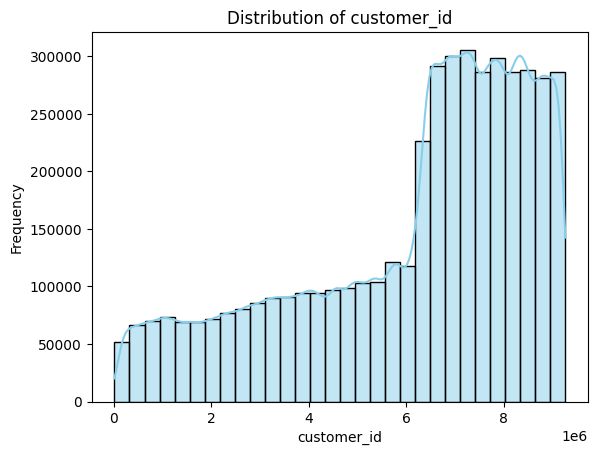

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn đã load dữ liệu
# user = pd.read_csv("user.csv")

# EDA cho cột 'customer_id' (biến số)
print("\nStatistics for customer_id:")
print(df_user['customer_id'].describe())
sns.histplot(df_user['customer_id'], kde=True, color="skyblue", bins=30)
plt.title('Distribution of customer_id')
plt.xlabel('customer_id')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# EDA cho cột 'user_id' (biến số)
print("\nStatistics for user_id:")
print(df_user['user_id'].describe())
sns.histplot(df_user['user_id'], kde=True, color="skyblue", bins=30)
plt.title('Distribution of user_id')
plt.xlabel('user_id')
plt.ylabel('Frequency')
plt.show()


Statistics for user_id:
shape: (4, 2)
┌────────────┬─────────────────────────────────┐
│ statistic  ┆ value                           │
│ ---        ┆ ---                             │
│ str        ┆ str                             │
╞════════════╪═════════════════════════════════╡
│ count      ┆ 4573964                         │
│ null_count ┆ 0                               │
│ min        ┆ 000004697bc1f0ecab42b6a3c2f0bc… │
│ max        ┆ fffffbd469d500229dd000e9fc48ed… │
└────────────┴─────────────────────────────────┘


KeyboardInterrupt: 